## Capstone 2. Credit card applications 

In this project we will build a machine learning model in order to automate the credit card approval process.

The business application is of great value, with this model financial institutions can make more efficient the credit risk modeling process.

It also can be applied to other business analysis , such as project finance and student loans applications.

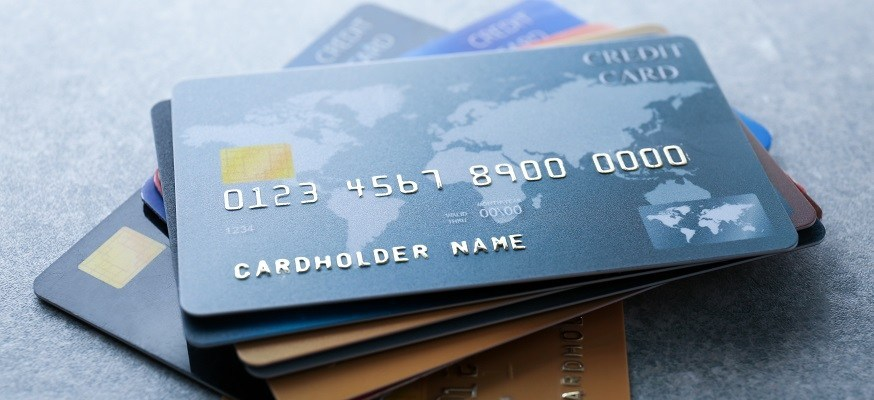

Set up the enviroment with the proper libraires.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('dark_background')

# Sklearn models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer,
)

from category_encoders import LeaveOneOutEncoder



## Exploratory Data Analysis

Bring the data into a pandas dataframe and make some data cleaning

In [2]:
# Save the dataset into a pandas dataframe:
df = pd.read_csv('Dataset/crx.data.csv')
df.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriverLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+


In [3]:
df.shape

(690, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriverLicense   690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


Looking at the first rows of the dataset, we can confirm the following points:

    * The dataset has a mix of categorical and numerical values.
    * Approved is the target variable, it has values of + for approved and - for rejected. Some type of label encoder will be required.
    * The dataframe has 690 observations and 15 features, it will be enough data for the model.
    * Some type of normalization, scaling will be required for the numerical values.

In [5]:
df['Married'].unique()

array(['u', 'y', '?', 'l'], dtype=object)

Next step is to check for missing values in the dataset. The missing values in the dataset are labeled with '?'.

In [6]:
# First we need to replace the character '?' with NaN values:
df = df.replace('?', np.NaN)
df.isna().sum()

Male              12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriverLicense      0
Citizen            0
ZipCode           13
Income             0
Approved           0
dtype: int64

In [7]:
# Next, impute missing values with the mean for numerical features:
df.fillna(df.mean(), inplace=True)

In [8]:
# With non numeric columns, replace NaN values with the most frequent observation:
for col in df.columns:
    if df[col].dtypes == 'object':
        df = df.fillna(df[col].value_counts().index[0])
df.isna().sum()    

Male              0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriverLicense     0
Citizen           0
ZipCode           0
Income            0
Approved          0
dtype: int64

Next step is to encode the categorical features to numerical using label encoder. 

In [9]:
encoder = LabelEncoder()

for col in df.columns:
        if df[col].dtypes=='object':
            df[col]=encoder.fit_transform(df[col])

Next we can start to analyse some plots in order to check for the relationships between the features and the target.

In [10]:
# Creating a heatmap for the correlation between each feature and the target:
corr_matrix = df.corr()[['Approved']].sort_values('Approved')
corr_matrix.style.background_gradient(cmap='coolwarm')

,Approved
PriorDefault,-0.720407
Employed,-0.458301
CreditScore,-0.406410
YearsEmployed,-0.322475
Debt,-0.206294
Income,-0.175657
Age,-0.133304
EducationLevel,-0.130026
ZipCode,-0.058633
DriverLicense,-0.031625


From the heatmap we can observe the following points:

    * Prior Default, Employed and Credit Score are the features with the most negative correlation to the target.
    * Married, Bank Customer and  Citizen are the features with the most positive correlation with the target.
    * Zip Code and Drivers License don't have much predicting power.

## Model Creation

The next step is to create a machine learning model in order to predict the target variable, we are going to perform several classification models and choose the best performer.

In [11]:
# Create variables X and y withthe features and target variables:
X = df.drop(columns=['Approved', 'ZipCode', 'DriverLicense'])
y = df['Approved']

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

Logistic Regression Model:

In [13]:
model_lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')
model_crossval = cross_val_score(model_lr, rescaledX_train, y_train, cv=5)
print('Accuracy scores for the 5 folds: ', model_crossval)
print('Mean cross validation score: {:.3f}'.format(model_crossval.mean()))

Accuracy scores for the 5 folds:  [0.84615385 0.89423077 0.88349515 0.83495146 0.85436893]
Mean cross validation score: 0.863


In [14]:
model_lr.fit(rescaledX_train, y_train)
y_pred = model_lr.predict(rescaledX_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,72,10
Actual 1,16,75


In [26]:
model_lr.score(rescaledX_train, y_train)

0.8684719535783365

In [28]:
model_lr.score(rescaledX_test, y_test)

0.8497109826589595

In [15]:
model_lr.coef_

array([[ 0.086653  , -0.2150387 ,  0.09915377,  2.00951715,  0.22937063,
        -0.39046042, -0.191789  , -0.92004095, -3.39655641, -1.0622435 ,
        -0.79190401,  0.07835898, -1.29285734]])

In [16]:

pd.DataFrame(dict(coef=model_lr.coef_[0], feat=X.columns, abs_coef=abs(model_lr.coef_[0]))).sort_values('abs_coef')

,coef,feat,abs_coef
11,0.078359,Citizen,0.078359
0,0.086653,Male,0.086653
2,0.099154,Debt,0.099154
6,-0.191789,Ethnicity,0.191789
1,-0.215039,Age,0.215039
4,0.229371,BankCustomer,0.229371
5,-0.390460,EducationLevel,0.390460
10,-0.791904,CreditScore,0.791904
7,-0.920041,YearsEmployed,0.920041
9,-1.062244,Employed,1.062244


Random Forest Model:

In [17]:
rf_clf = RandomForestClassifier(n_estimators=24)
rf_cv_scores = cross_val_score(rf_clf, rescaledX_train, y_train, cv=5)

print('Accuracy scores for the 5 folds: ', rf_cv_scores)
print('Mean cross validation score: {:.3f}'.format(rf_cv_scores.mean()))

Accuracy scores for the 5 folds:  [0.875      0.84615385 0.86407767 0.84466019 0.85436893]
Mean cross validation score: 0.857


In [18]:
rf_clf.fit(rescaledX_train, y_train)
y_pred = rf_clf.predict(rescaledX_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,65,17
Actual 1,9,82


In [19]:
pd.DataFrame(dict(coef=rf_clf.feature_importances_, feat=X.columns)).sort_values('coef')

,coef,feat
11,0.009611,Citizen
0,0.014495,Male
4,0.015632,BankCustomer
3,0.022184,Married
6,0.027897,Ethnicity
9,0.063300,Employed
5,0.065648,EducationLevel
1,0.081889,Age
7,0.091367,YearsEmployed
10,0.092494,CreditScore


KNN Neighbors:

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rescaledX_train, y_train)
print('Accuracy for train set: {:.3f}'.format(knn.score(rescaledX_train, y_train)))
print('Accuracy for train set: {:.3f}'.format(knn.score(rescaledX_test, y_test)))

Accuracy for train set: 0.882
Accuracy for train set: 0.861


In [21]:
knn.fit(rescaledX_train, y_train)
y_pred = knn.predict(rescaledX_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,68,14
Actual 1,10,81


XGB Classifier

In [22]:
pipeline = Pipeline([
    ('xgb', XGBClassifier(random_state=42, colsample_bytree=0.5, max_depth=2))
])

In [23]:
pipeline.fit(rescaledX_train, y_train)

train_score = pipeline.score(rescaledX_train, y_train)
test_score = pipeline.score(rescaledX_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9497098646034816
Test score: 0.8497109826589595


In [24]:
y_pred = pipeline.predict(rescaledX_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,67,15
Actual 1,11,80


In [25]:
pd.DataFrame(dict(coef=pipeline['xgb'].feature_importances_, feat=X.columns)).sort_values('coef')

,coef,feat
11,0.011800,Citizen
1,0.017364,Age
0,0.017917,Male
5,0.018085,EducationLevel
2,0.019868,Debt
6,0.020428,Ethnicity
3,0.026776,Married
7,0.031942,YearsEmployed
12,0.033886,Income
4,0.055435,BankCustomer
